# Flight Data

Source: Bureau of Transportation. “[https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236)”.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
df = pd.read_csv('data/data.csv')
del df['Unnamed: 5']
df.head()

,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY_NEW
0,2014-01-01,AA,JFK,LAX,14.0
1,2014-01-01,AA,LAX,JFK,122.0
2,2014-01-01,AA,JFK,LAX,0.0
3,2014-01-01,AA,DFW,HNL,2.0
4,2014-01-01,AA,OGG,DFW,0.0


In [3]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256548 entries, 0 to 17256547
Data columns (total 5 columns):
FL_DATE           datetime64[ns]
UNIQUE_CARRIER    object
ORIGIN            object
DEST              object
DEP_DELAY_NEW     float64
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 658.3+ MB


In [4]:
g = df.set_index('FL_DATE')
origin = g[['ORIGIN','UNIQUE_CARRIER']].groupby(['ORIGIN',pd.TimeGrouper('M')]).count()
origin.head()

UNIQUE_CARRIER
ORIGIN FL_DATE                   
ABE    2014-01-31             135
       2014-02-28             123
       2014-03-31             190
       2014-04-30             183
       2014-05-31             169

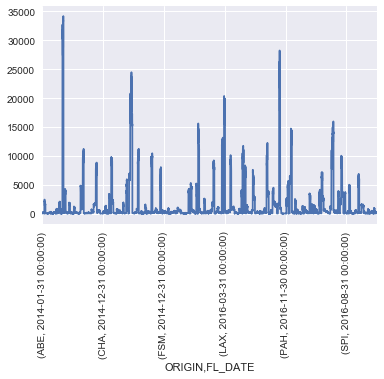

In [5]:
origin.plot(legend=False)
plt.xticks(rotation=90)

plt.show()

In [6]:
dest = g[['DEST','UNIQUE_CARRIER']].groupby(['DEST',pd.TimeGrouper('M')]).count()
dest.head()

UNIQUE_CARRIER
DEST FL_DATE                   
ABE  2014-01-31             137
     2014-02-28             125
     2014-03-31             189
     2014-04-30             183
     2014-05-31             169

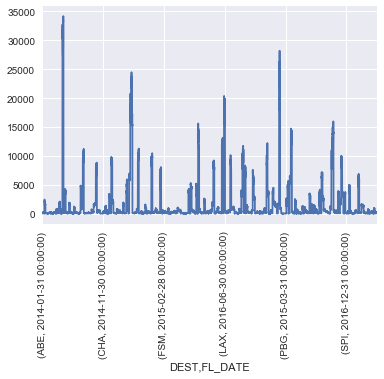

In [7]:
dest.plot(legend=False)
plt.xticks(rotation=90)
plt.show()

In [8]:
ly = df[df['FL_DATE'] >= datetime.date(2016,1,1)]
ly.head()

,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY_NEW
11638890,2016-01-01,HA,HNL,LAS,0.0
11638891,2016-01-01,HA,SMF,HNL,0.0
11638892,2016-01-01,HA,HNL,SMF,3.0
11638893,2016-01-01,HA,SEA,HNL,7.0
11638894,2016-01-01,HA,HNL,SEA,12.0


In [9]:
dest = ly[['ORIGIN','DEST']].groupby('DEST').count()
orig = ly[['ORIGIN','DEST']].groupby('ORIGIN').count()
cts = dest.join(orig, how='outer')
cts['count'] = cts['ORIGIN'] + cts['DEST']
del cts['ORIGIN']
del cts['DEST']
cts.head()

,count
ABE,4738.0
ABI,322.0
ABQ,37935.0
ABR,1486.0
ABY,2005.0


In [10]:
busiest = cts.sort_values(['count'],ascending=False).head(150)
busiest.head()

,count
ATL,768627.0
ORD,487971.0
DEN,452361.0
LAX,425955.0
DFW,392080.0


In order to map locations, airport coordinate data was obtained from [Open Flights](https://openflights.org/data.html).

In [11]:
codes = pd.read_csv('data/airports.csv')
codes.head(3)

,Num,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


In [12]:
bl = busiest.merge(codes, left_index=True, right_on='IATA', how='left')
bl.head(3)

,count,Num,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
3467,768627.0,3682,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,1026,-5,A,America/New_York,airport,OurAirports
3611,487971.0,3830,Chicago O'Hare International Airport,Chicago,United States,ORD,KORD,41.978600,-87.904800,672,-6,A,America/Chicago,airport,OurAirports
3533,452361.0,3751,Denver International Airport,Denver,United States,DEN,KDEN,39.861698,-104.672997,5431,-7,A,America/Denver,airport,OurAirports


/Users/macbook/anaconda/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/macbook/anaconda/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/macbook/anaconda/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


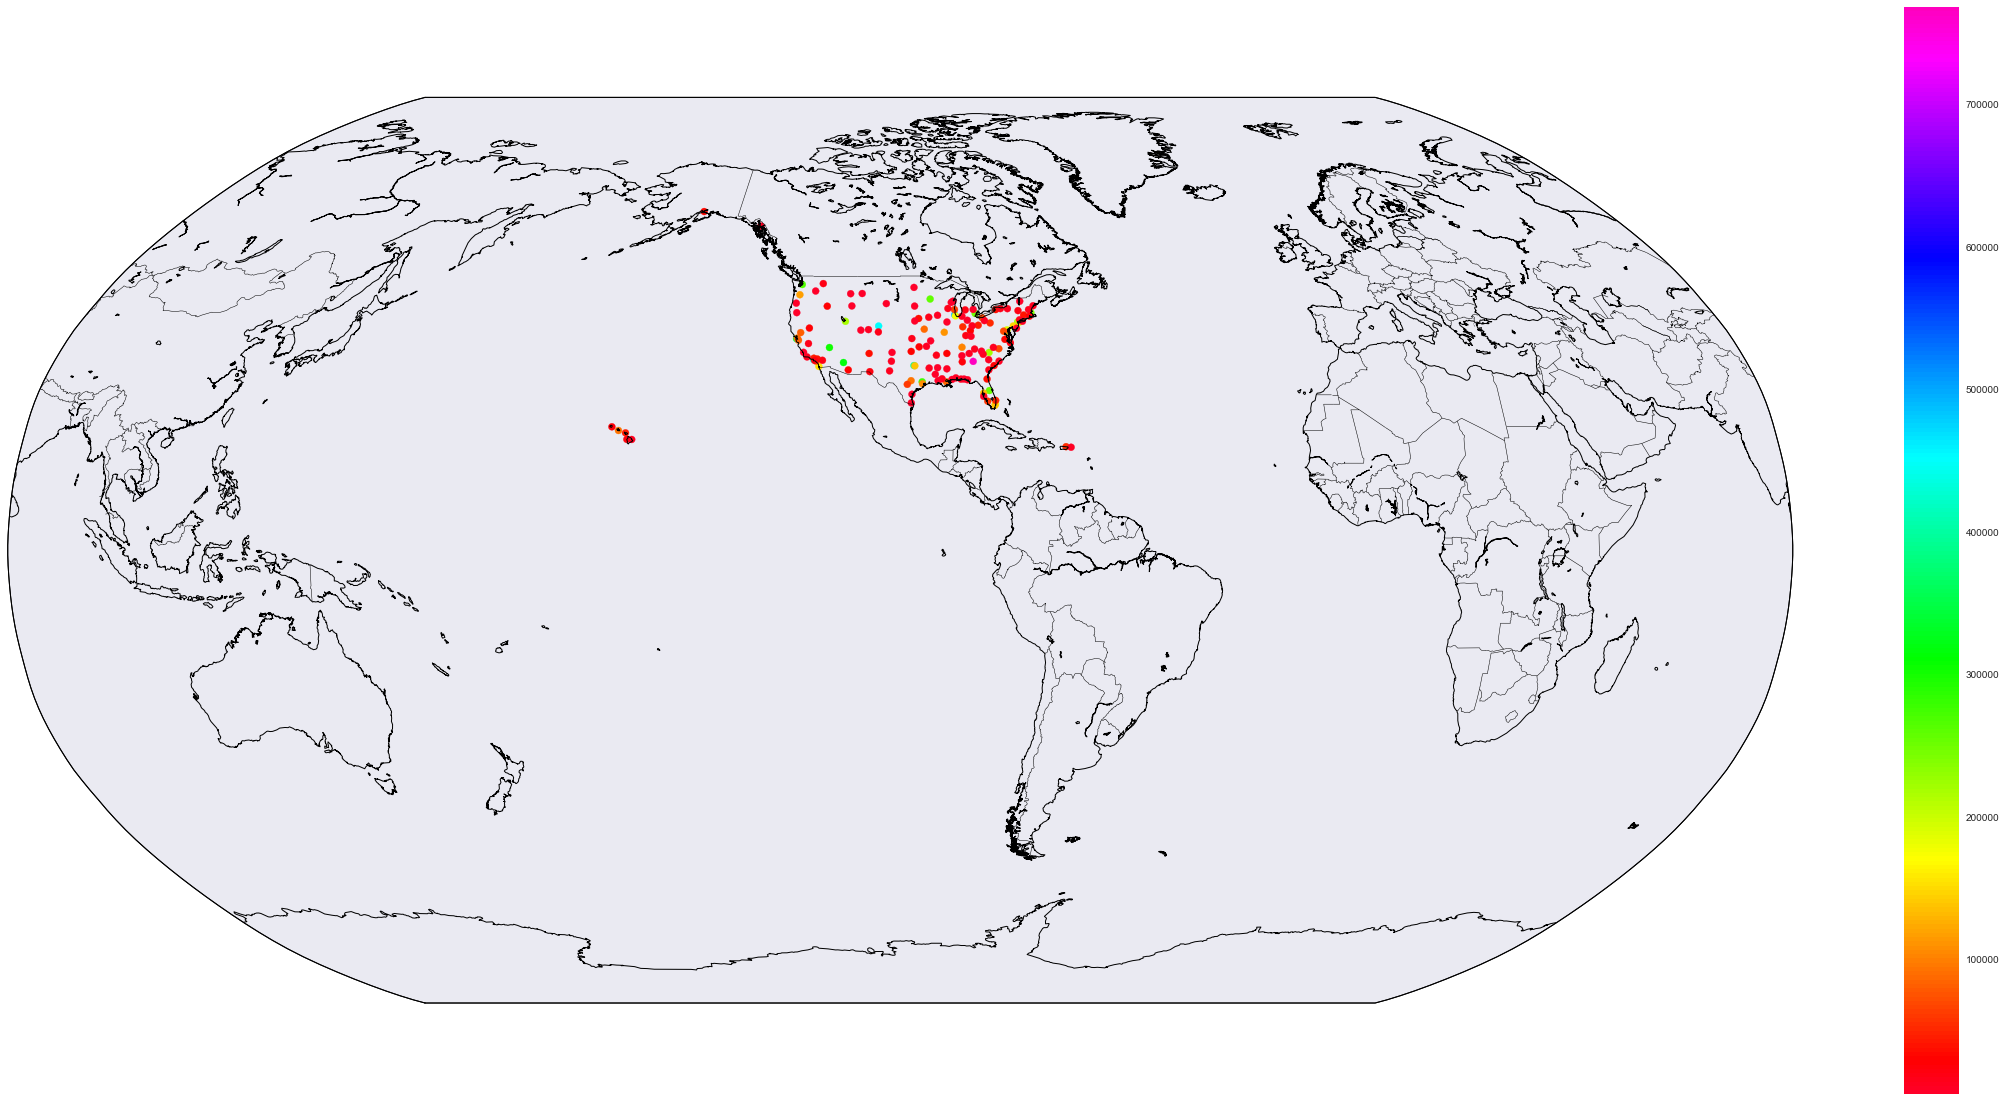

In [13]:
from mpl_toolkits.basemap import Basemap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plt.figure(figsize=(40,20))

map = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=1000.0)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()

lons = bl['Longitude'].values
lats = bl['Latitude'].values
x,y = map(lons, lats)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('gist_rainbow')
colorlist = bl['count'].values
map.scatter(x, y, c=colorlist, cmap = cm, marker='o')
 
#labels = bl['Name'].values
#for label, xpt, ypt in zip(labels, x, y):
#    plt.text(xpt, ypt, label)

plt.colorbar()
plt.show()

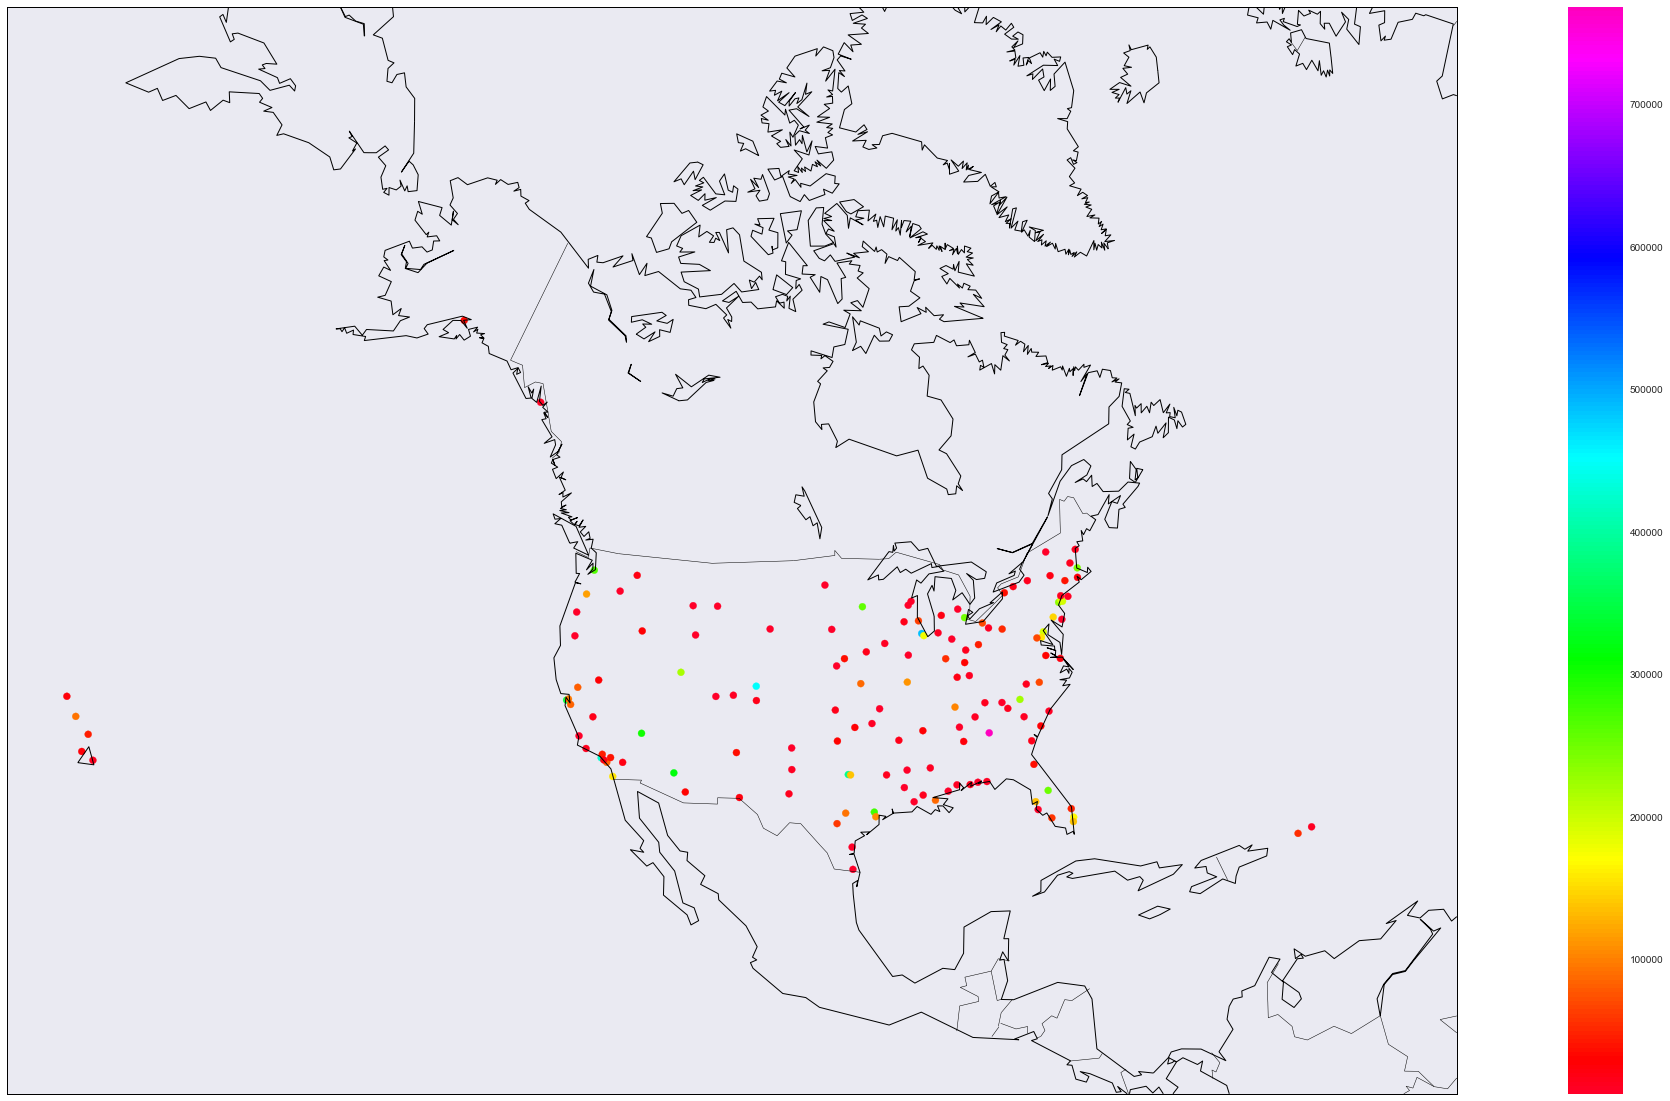

In [15]:
from mpl_toolkits.basemap import Basemap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plt.figure(figsize=(40,20))

map = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()

lons = bl['Longitude'].values
lats = bl['Latitude'].values
x,y = map(lons, lats)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('gist_rainbow')
colorlist = bl['count'].values
map.scatter(x, y, c=colorlist, cmap = cm, marker='o')
 
#labels = bl['Name'].values
#for label, xpt, ypt in zip(labels, x, y):
#    plt.text(xpt, ypt, label)

plt.colorbar()
plt.show()

In [ ]:
ly.head()

In [ ]:
delays = ly.groupby(['FL_DATE','ORIGIN'], as_index=False).agg('mean')
delays.reset_index()
delays.head()

In [ ]:
delays['month'] = delays['FL_DATE'].dt.month
delays.head()

In [ ]:
y = delays['DEP_DELAY_NEW']
X = delays[['month', 'ORIGIN']]

A random forest regressor would work best here, as the outcome delay length is dependent on classification of origin airport and classification of time period.

In [ ]:
ds = df[df['DEP_DELAY_NEW'] > 0].groupby('UNIQUE_CARRIER').agg('count')
ds['DEP_DELAY_NEW'].sort_values(ascending=False)

In [ ]:
ds['DEP_DELAY_NEW'].sort_values().plot(kind='barh', legend=False)

In [ ]:
ds['DEP_DELAY_NEW'].mean()

In [ ]:
ds['DEP_DELAY_NEW'].std()

In [ ]:
stats.shapiro(ds['DEP_DELAY_NEW'])

In [ ]:
ly.head()

In [ ]:
ly['delayed'] = ly['DEP_DELAY_NEW'].map(lambda x: 1 if x > 0 else 0)

In [ ]:
ly.head()

In [ ]:
y1 = ly['DEP_DELAY_NEW']
y2 = ly['delayed']
X = ly[['FL_DATE','UNIQUE_CARRIER','ORIGIN','DEST']]